### `STAGE 1`: Import relevant packages 

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import io
import warnings
warnings.filterwarnings("ignore")

from pyvis.network import Network
from tqdm import tqdm
from zipfile import ZipFile
from statsmodels.tsa.seasonal import STL
from causalimpact import CausalImpact
from utils import (
    decompose_signal, 
    compare_promo_regular_sales, 
    calculate_causal_impact_with_covariates, 
    split_promos_into_sequences
)

### `STAGE 2`: Read & Transform data 

In [2]:
# read dimension data
product_hierarchy = pd.read_csv('./data/product_hierarchy.csv')
store_cities = pd.read_csv('./data/store_cities.csv')

# read fact data
sales_zip = ZipFile('./data/sales.csv.zip', 'r')
sales_data = sales_zip.read('sales.csv')
sales_bytes = io.BytesIO(sales_data)
sales_bytes.seek(0)
sales = pd.read_csv(sales_bytes, converters={'promo_bin_1':str,'promo_bin_2':str,'promo_discount_type_2':str})

df = sales.query("sales != 0 and ~sales.isnull()").reset_index(drop=True) # remove null or no sales lines
df["date"] = pd.to_datetime(df["date"]) # convert to datetime format
df['promo'] = df[['promo_bin_1','promo_bin_2']].sum(axis=1) != '' # assume that product is in promotion when it is involved in promotion bin 1 or promotion bin 2

df_sales = df.reindex(columns=['product_id', 'store_id', 'date', 'revenue', 'promo']) # pick only columns in need, to reduce the data size in memory

- There are `144` stores serving `629` products to customers. The sales data limits date range from 2017-01-02 to 2019-10-31 (1033 days in total).
- `529` products used to be in promotion.
- All stores sell at least one product in promotion.
- Nearly `120` stores are mature when serving their customers over 900 days

In [3]:
# describe the sales data
df_sales.describe(include=["object","datetime"])

,product_id,store_id,date
count,3189682,3189682,3189682
unique,629,144,1033
top,P0103,S0085,2018-06-14 00:00:00
freq,114022,92706,4316
first,NaN,NaN,2017-01-02 00:00:00
last,NaN,NaN,2019-10-31 00:00:00


In [4]:
# get to know how many products are in promotion
df_sales.groupby("product_id")["promo"].max().value_counts()

True     529
False    100
Name: promo, dtype: int64

In [5]:
# get to know how many stores sells products in promotion
df_sales.groupby("store_id")["promo"].max().value_counts()

True    144
Name: promo, dtype: int64

<AxesSubplot: >

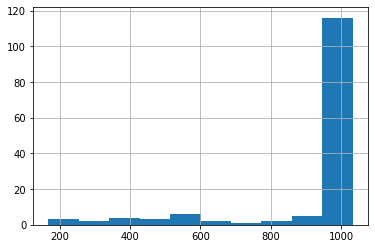

In [6]:
# calculate total revenue by store per day
df_sales_daily = df_sales.groupby(["store_id","date"]).agg(total_revenue=("revenue","sum"))
# number of sales days by store
df_sales_daily.reset_index().groupby("store_id")["date"].count().hist()

### `STAGE 3`: Define initial parameters

In [7]:
def_colours = plt.rcParams['axes.prop_cycle'].by_key()['color'] # make the list of hex colors
period_in_days = 7 # assume that revenue is 7-day periodical and at peak during the weekends

### `STAGE 4`: Decomposition

it seems that the revenue of store S0084 dose not follow any trend like peaking during the weekends...

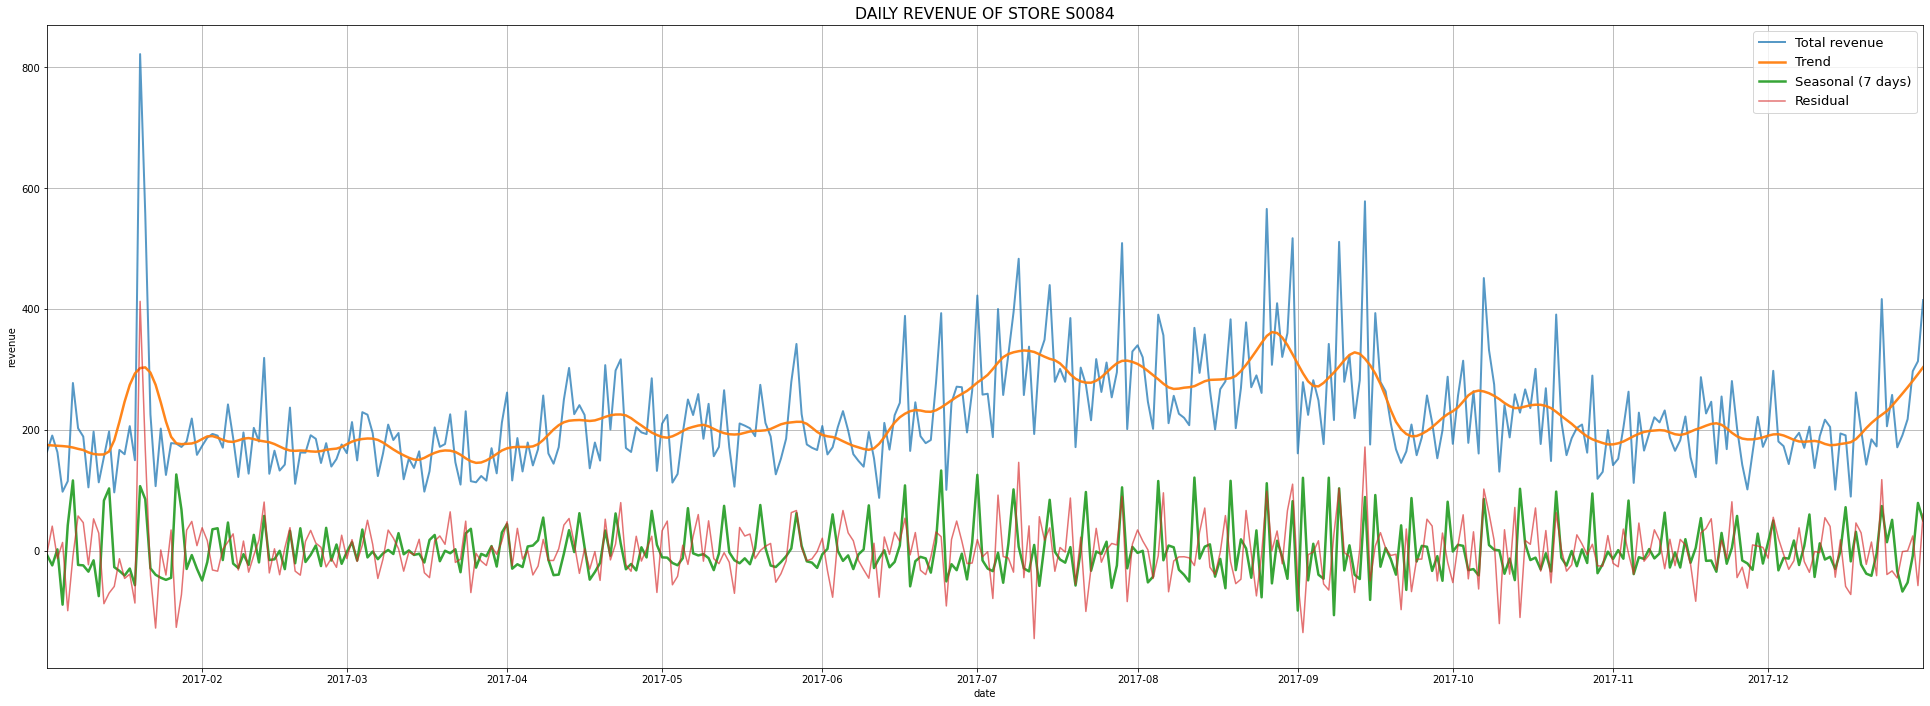

In [9]:
# use store S0084 as a sample
df_sales_S0084 = df_sales_daily[(df_sales_daily.index.get_level_values(0)=="S0084")&(df_sales_daily.index.get_level_values(1).year==2017)]
df_sales_S0084_daily = df_sales_S0084.reset_index(level=0)["total_revenue"]

# Fig sizes
fig_h = 10/1.5
fig_w = 18/1.5

fig, ax = plt.subplots(1,1,figsize=(fig_w*1.5*1.5, fig_h*1.5))
font_size = 13
plt.rcParams.update({'font.size': font_size})
do_save_decomposition = True

x_axis = df_sales_S0084_daily.index
period_in_days=7



decomposition_results = decompose_signal(df_sales_S0084_daily, period_in_days=period_in_days, minimum_heartbeat=0.85)
df_decomposition = pd.DataFrame(decomposition_results)

idx_store = 0

ax.plot(x_axis, df_sales_S0084_daily, label=f'Total revenue', color=def_colours[idx_store], linewidth=1+1, alpha=0.75)

ax.plot(x_axis, df_decomposition['trend'], label=f'Trend', color=def_colours[idx_store+1], linewidth=1.5+1, alpha=0.95)

ax.plot(x_axis, df_decomposition['seasonal'], label=f'Seasonal ({period_in_days} days)', color=def_colours[idx_store+2], linewidth=1.5+1, alpha=0.95)

ax.plot(x_axis, df_decomposition['residual'], label=f'Residual', color=def_colours[idx_store+3], linewidth=0.5+1, alpha=0.65)


plt.legend()
plt.xlabel('date')
plt.ylabel('revenue')
plt.title("DAILY REVENUE OF STORE S0084")
plt.grid(True)
plt.tight_layout()
plt.margins(0,0.05)


In [10]:
df_sales_pivot = df_sales.pivot(index=["store_id","date"], columns="product_id", values="revenue")
df_sales_pivot.fillna(0, inplace=True)
df_sales_pivot = df_sales_pivot.merge(df_sales_daily, left_index=True, right_index=True)

In [11]:
df_promotion_pivot = df_sales.pivot(index=["store_id","date"], columns="product_id", values="promo")
df_promotion_pivot.fillna(False, inplace=True)

product_list = list(df_promotion_pivot.columns)

In [12]:
df_heartbeat_flag = pd.DataFrame(index=df_sales_pivot.index)

# Season-Trend decomposition using LOESS
for product_A in tqdm(product_list):
    hearbeat_flag = df_sales_pivot.groupby(level=0)[product_A].transform(lambda series: decompose_signal(series, period_in_days=period_in_days, minimum_heartbeat=0.85)['heartbeat_flag'])
    df_heartbeat_flag = pd.concat([df_heartbeat_flag, hearbeat_flag], axis=1)

100%|██████████| 629/629 [16:13<00:00,  1.55s/it]


In [13]:
df_trend_pivot = pd.DataFrame(index=df_sales_pivot.index)

# Season-Trend decomposition using LOESS
for product_A in tqdm(product_list):
    trend = df_sales_pivot.groupby(level=0)[product_A].transform(lambda series: decompose_signal(series, period_in_days=period_in_days, minimum_heartbeat=0.85)['trend'])
    df_trend_pivot = pd.concat([df_trend_pivot, trend], axis=1)

100%|██████████| 629/629 [17:19<00:00,  1.65s/it]


In [14]:
df_residual_pivot = pd.DataFrame(index=df_sales_pivot.index)

# Season-Trend decomposition using LOESS
for product_A in tqdm(product_list):
    residual = df_sales_pivot.groupby(level=0)[product_A].transform(lambda series: decompose_signal(series, period_in_days=period_in_days, minimum_heartbeat=0.85)['residual'])
    df_residual_pivot = pd.concat([df_residual_pivot, residual], axis=1)

100%|██████████| 629/629 [16:42<00:00,  1.59s/it]


In [15]:
# List of products
sku_analysis = []

min_promo_days=5
min_regular_days=10
holidays = pd.Series([]).astype("datetime64[ns]") # assume that there is no holiday effect

for product_A in tqdm(product_list):

    temp1 = pd.concat([
            df_sales_pivot[[product_A]].rename(columns={product_A:"revenue"}), 
            df_promotion_pivot[[product_A]].rename(columns={product_A:"promo"}), 
            df_heartbeat_flag[[product_A]].rename(columns={product_A:"heartbeat"})
        ], axis=1)
    
    for store_id, temp2 in temp1.groupby(level=0):
        
        idx_holiday_to_exclude = temp2.index.get_level_values(1).isin(holidays)
        product_behaviour = compare_promo_regular_sales(
            sales=temp2["revenue"], 
            promo=temp2["promo"],
            inferred_availability=temp2["heartbeat"],
            idx_holiday_to_exclude=idx_holiday_to_exclude,
            min_promo_days=min_promo_days, 
            min_regular_days=min_regular_days
        )

        if product_behaviour != []:
            temp3 = product_behaviour[0]
            temp3["product_id"] = product_A
            temp3["store_id"] = store_id
            sku_analysis.append(temp3)
            
    
# Stick the dicts into a DF
df_snap_stats = pd.DataFrame(sku_analysis)
df_snap_stats.set_index(["store_id","product_id"], inplace=True)
# clean the empty dictionaries
idx_nonsense = df_snap_stats.num_promo_slots.isna() | (df_snap_stats.num_promo_slots < 1)
df_snap_stats = df_snap_stats[~idx_nonsense].copy()

# for backwards compatibility
df_snap_stats['mu_difference'] = df_snap_stats['difference_averages_promo_to_regular']
# Add a small offset to avoid 0-divisions
df_snap_stats['mu_delta'] = df_snap_stats.apply(lambda snap_reg: (snap_reg['avg_promo_sales']+0.01)/(snap_reg['avg_regular_sales']+0.01), axis=1)

# save the file
df_snap_stats.sort_values(by=['mu_delta'], ascending=False, inplace=True)

100%|██████████| 629/629 [02:00<00:00,  5.23it/s]


In [16]:
# Potential cannibals
# This threshold is used to detect uplifters based on the difference in average sales
sales_threshold = 1/3
# min AVG sales to be considered
min_avg_sales = 2

# A bit of work on the uplifters
# Snap sales greater than the sales + threshold
idx_A = df_snap_stats['mu_delta']>=(1+sales_threshold)

# Comparison only valid if they are not zero sales
idx_B = (df_snap_stats['avg_promo_sales']>min_avg_sales) & (df_snap_stats['avg_regular_sales']>min_avg_sales)
df_snap_stats['uplift_in_median'] = (idx_A & idx_B)

# Get two groups: potential cannibals (and haloers) and victims
df_snap_uplifters = df_snap_stats[df_snap_stats['uplift_in_median']].copy()

In [ ]:
# If true, use the sales without the weekly pattern
do_decomposition = False

# This is the minimum bump between regular and promo
# and promo back to regular *0.25
min_diff_in_units_from_reg_to_promo = 2

# values for the CI analysis
min_ratio_change = 0.4
do_exclude_promos_SKU_B = True
# This flag is pretty good for debugging/development
be_verbose=False

# Option to deseasonalise
sku_potential_cannibals = df_snap_uplifters.index.tolist()

df_CI_analysis = pd.DataFrame()

total_cannibals = len(sku_potential_cannibals)

for idx, dimension in enumerate(sku_potential_cannibals):

    store_id, product_A = dimension
    print(f'{idx}/{total_cannibals}:{store_id}-{product_A}')

    df_promotion_sub = df_promotion_pivot[df_promotion_pivot.index.get_level_values(0)==store_id].reset_index(level=0)
    df_heartbeat_sub = df_heartbeat_flag[df_heartbeat_flag.index.get_level_values(0)==store_id].reset_index(level=0)
    df_sales_sub = df_sales_pivot[df_sales_pivot.index.get_level_values(0)==store_id].reset_index(level=0)
    df_trend_sub = df_trend_pivot[df_trend_pivot.index.get_level_values(0)==store_id].reset_index(level=0)
    df_residual_sub = df_residual_pivot[df_residual_pivot.index.get_level_values(0)==store_id].reset_index(level=0)
    idx_holiday_to_exclude = df_sales_sub.index.isin(holidays)

    # Get the promotions and split them into slots
    promo_sku_A = df_promotion_sub[product_A]
    idx_pre_intervention, idx_post_intervention = split_promos_into_sequences(promo_sku_A, min_promo_days=min_promo_days, min_regular_days=min_regular_days)

    availability_sku_A = df_heartbeat_sub[product_A]
    availability_value_sku_A = availability_sku_A.sum()/len(availability_sku_A)
    flag_min_availability_sku_A = availability_value_sku_A > 0.9

    # TO-DO: Decomposition should be done according to the SKU's patterns
    if flag_min_availability_sku_A & do_decomposition:
        sales_sku_A = df_trend_sub[product_A] + df_residual_sub[product_A]
    else:
        sales_sku_A = df_sales_sub[product_A]


    # go through all the SKUs in the store
    sku_potential_victims = product_list.copy()
    category_A = product_hierarchy[product_hierarchy["product_id"]==product_A]["hierarchy1_id"].iloc[0]
    sku_potential_victims = product_hierarchy[
        (product_hierarchy["hierarchy1_id"]==category_A)&       # cannibalization should be only considered when products are in the same category
        (product_hierarchy["product_id"]!=product_A)&           # product B must be different from product A
        (product_hierarchy["product_id"].isin(product_list))    # product B must have revenue
    ]["product_id"].tolist()

    for product_B in sku_potential_victims:
        availability_sku_B = df_heartbeat_sub[product_B]
        promo_sku_B = df_promotion_sub[product_B]

        # Decide what to do with sku_B on promo
        # - Remove the promo days? when? outside the cannibalisation window?
        # - We should compare windows of pre/post promo, not the entire year
        availability_value_sku_B = availability_sku_B.sum()/len(availability_sku_B)
        flag_min_availability_sku_B = availability_value_sku_B > 0.9

        if flag_min_availability_sku_B & do_decomposition:
            sales_sku_B = df_residual_sub[product_B] + df_trend_sub[product_B]
        else:
            sales_sku_B = df_sales_sub[product_B]
        
        ci_analysis = calculate_causal_impact_with_covariates(
                promo_sku_A=promo_sku_A,
                availability_sku_A=availability_sku_A,
                sales_sku_B=sales_sku_B, 
                promo_sku_B=promo_sku_B,
                availability_sku_B=availability_sku_B,
                idx_pre_intervention=idx_pre_intervention,
                idx_post_intervention=idx_post_intervention,
                idx_holiday_to_exclude=idx_holiday_to_exclude,
                min_diff_in_units_from_reg_to_promo=min_diff_in_units_from_reg_to_promo,
                min_ratio_change=min_ratio_change,
                do_exclude_promos_SKU_B=do_exclude_promos_SKU_B,
                be_verbose=be_verbose,
                min_overlapping_days_promo=min_promo_days,
                min_overlapping_days_regular=min_regular_days
            )
        if ci_analysis != []:
            print(f">>> {product_B}")
            causal_impact_analysis = pd.DataFrame(ci_analysis)
            causal_impact_analysis[["store_id","product_id_A","product_id_B"]] = store_id, product_A, product_B
            df_CI_analysis = pd.concat([df_CI_analysis, causal_impact_analysis])

In [25]:
# save CI analysis results for further reuse
df_CI_analysis.to_csv("./data/ci_analysis_results.csv", index=False)

<AxesSubplot: >

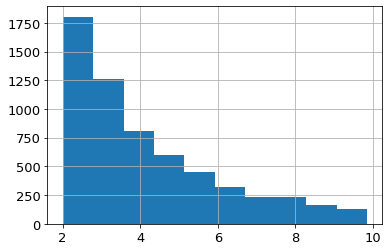

In [44]:
df_CI_analysis.diff_in_units_from_reg_to_promo.sort_values().head(6000).hist()

<AxesSubplot: >

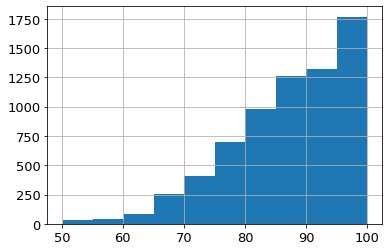

In [49]:
df_CI_analysis.prob_causal_effect.hist()

In [73]:
hierarchy_level = "hierarchy5_id"
df_CI_analysis\
    .reindex(columns=["store_id","product_id_A","product_id_B","prob_causal_effect","diff_in_units_from_reg_to_promo","diff_in_units_from_promo_to_pos_promo"])\
    .merge(product_hierarchy[["product_id",hierarchy_level]].rename(columns=lambda x: x+'_A'))\
    .merge(product_hierarchy[["product_id",hierarchy_level]].rename(columns=lambda x: x+'_B'))\
    .query(f"{hierarchy_level}_A == {hierarchy_level}_B")\
    .shape[0] / df_CI_analysis.shape[0] * 100

1.198304837059769

In [74]:
hierarchy_level = "hierarchy5_id"
df_CI_analysis\
    .reindex(columns=["store_id","product_id_A","product_id_B","prob_causal_effect","diff_in_units_from_reg_to_promo","diff_in_units_from_promo_to_pos_promo"])\
    .merge(product_hierarchy[["product_id",hierarchy_level]].rename(columns=lambda x: x+'_A'))\
    .merge(product_hierarchy[["product_id",hierarchy_level]].rename(columns=lambda x: x+'_B'))\
    .query(f"{hierarchy_level}_A == {hierarchy_level}_B")\
    .sort_values("prob_causal_effect", ascending=False)

,store_id,product_id_A,product_id_B,prob_causal_effect,diff_in_units_from_reg_to_promo,diff_in_units_from_promo_to_pos_promo,hierarchy5_id_A,hierarchy5_id_B
1619,S0085,P0500,P0569,100.000000,15.862857,-2.337000,H0004000017,H0004000017
1620,S0038,P0500,P0569,100.000000,9.611905,-3.253333,H0004000017,H0004000017
690,S0108,P0548,P0103,99.900100,5.607716,-5.025154,H0000030001,H0000030001
691,S0049,P0548,P0103,99.900100,13.943445,-30.016857,H0000030001,H0000030001
1628,S0023,P0500,P0569,99.900100,3.902586,-3.157000,H0004000017,H0004000017
...,...,...,...,...,...,...,...,...
6839,S0085,P0543,P0245,79.820180,2.749000,-4.583000,H0003120001,H0003120001
4716,S0020,P0187,P0280,77.222777,3.210833,-8.972333,H0313030201,H0313030201
1140,S0002,P0051,P0261,75.024975,12.297712,-24.703091,H0003140912,H0003140912
4579,S0097,P0721,P0405,71.528472,3.233882,-8.044000,H0108090001,H0108090001


In [75]:
store_id = 'S0085'
product_id_A = 'P0500'
product_id_B = 'P0569'

df_CI = df_CI_analysis[
    (df_CI_analysis["store_id"]==store_id) &
    (df_CI_analysis["product_id_A"]==product_id_A) &
    (df_CI_analysis["product_id_B"]==product_id_B)
]
df_CI.iloc[0]

slot_number                                                                       4
idx_regular_days                         [2017-08-10 00:00:00, 2017-10-04 00:00:00]
idx_promo_days                           [2017-10-05 00:00:00, 2017-10-18 00:00:00]
total_overlapping_days_regular                                                   56
regular_to_promo_gap                                                              0
total_overlapping_days_promo                                                     14
competing_promo_days                                                              0
sku_B_regular_avg_sales                                                   32.467857
sku_B_avg_sales_during_promo_sku_A                                           16.605
diff_in_units_from_reg_to_promo                                           15.862857
diff_in_units_from_promo_to_pos_promo                                        -2.337
ratio_change                                                               0

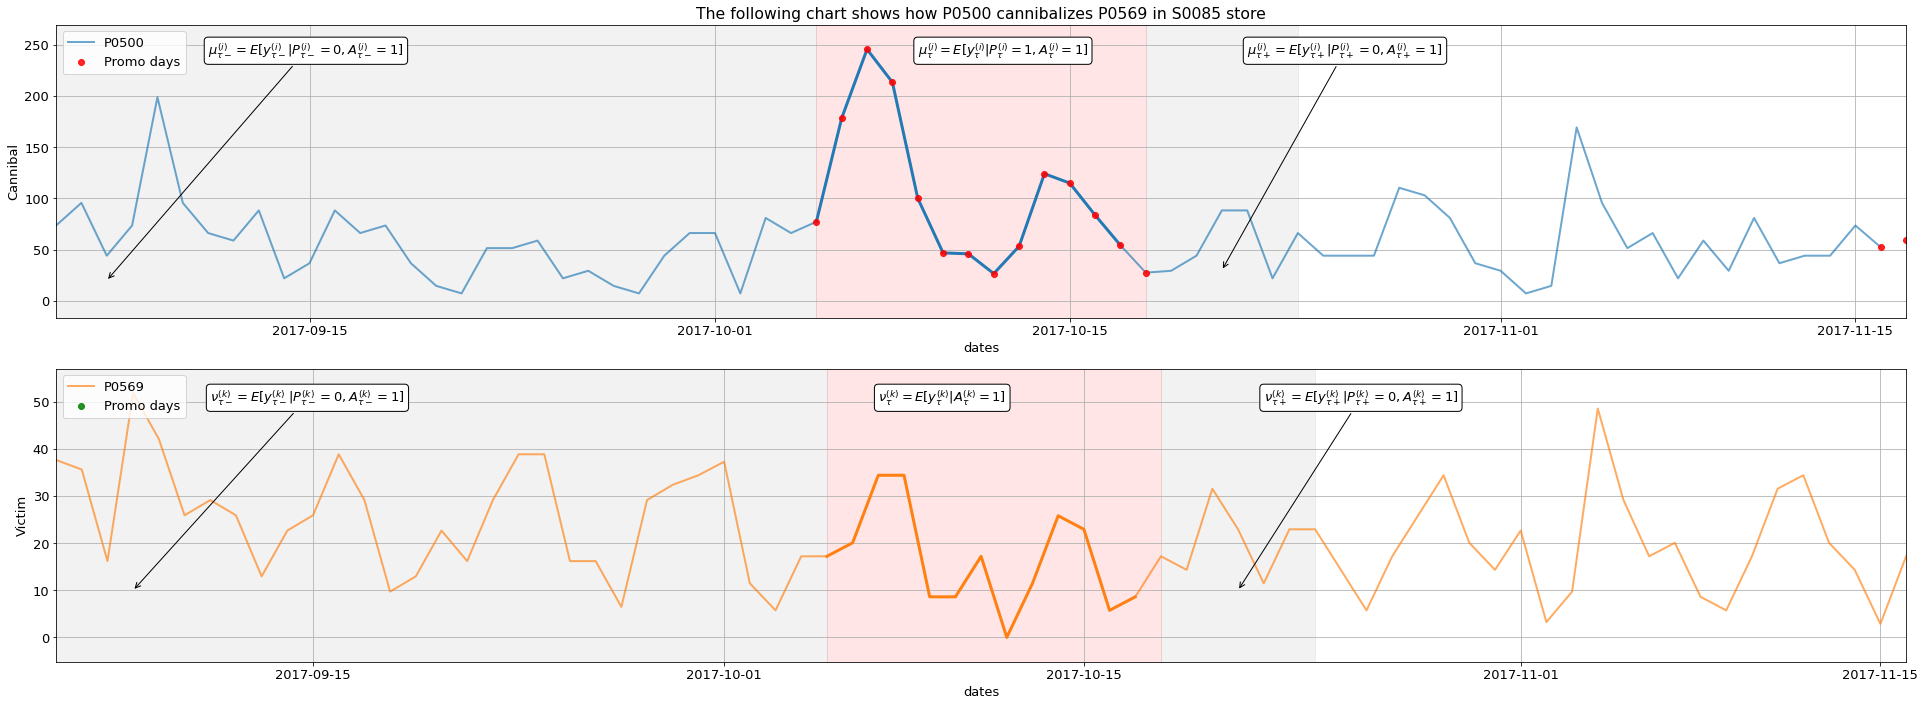

In [120]:
# save_figure = True

# Plot one store
fig, ax = plt.subplots(2,1,figsize=(fig_w*1.5*1.5, fig_h*1.5))

df_sales_sub = df_sales_pivot[df_sales_pivot.index.get_level_values(0)==store_id].reset_index(level=0)
df_promo_sub = df_promotion_pivot[df_promotion_pivot.index.get_level_values(0)==store_id].reset_index(level=0)
sales_sku_A = df_sales_sub[product_id_A]
sales_sku_B = df_sales_sub[product_id_B]
promo_sku_A = df_promo_sub[product_id_A]
promo_sku_B = df_promo_sub[product_id_B]

total_days = sales_sku_A.shape[0]
num_days = sales_sku_A.index

start_period = df_CI.idx_promo_days[0][0]
end_period = df_CI.idx_promo_days[0][1]
start_period_loc = num_days.get_loc(start_period)
end_period_loc = num_days.get_loc(end_period)

xaxis_offset = 30
start_plot = start_period_loc - xaxis_offset
end_plot = end_period_loc + xaxis_offset

sku_B_reg = df_CI['sku_B_regular_avg_sales'][0]
sku_B_cannibalised = df_CI['sku_B_avg_sales_during_promo_sku_A'][0]
sku_B_predicted = df_CI['avg_predicted'][0]

slot_number = df_CI['slot_number'][0]

x_axis = num_days

idx_store = 0
idx_axis = 0

ax[0].plot(x_axis[start_plot:end_plot], sales_sku_A[start_plot:end_plot], label=f'{product_id_A}', color=def_colours[idx_store], linewidth=2, alpha=0.65)

ax[1].plot(x_axis[start_plot:end_plot], sales_sku_B[start_plot:end_plot], label=f'{product_id_B}', color=def_colours[idx_store+1], linewidth=2, alpha=0.65)

ax[0].plot(x_axis[start_period_loc:end_period_loc], sales_sku_A[start_period_loc:end_period_loc], color=def_colours[idx_store], linewidth=3, alpha=0.95)

ax[1].plot(x_axis[start_period_loc:end_period_loc], sales_sku_B[start_period_loc:end_period_loc], color=def_colours[idx_store+1], linewidth=3, alpha=0.95)

ax[0].axvspan(start_period, end_period, alpha=0.1, color='red')
ax[1].axvspan(start_period, end_period, alpha=0.1, color='red')

# Work out promo A days
mask_sku_A = np.zeros(total_days, dtype=bool)
mask_sku_A[start_plot:end_plot+1]=True

masked_promo_A = promo_sku_A & mask_sku_A
ax[0].plot(x_axis[masked_promo_A], sales_sku_A[masked_promo_A], 'o', label=f'Promo days', color='r', linewidth=2.5, alpha=0.85)


mask_sku_B = np.zeros(total_days, dtype=bool)
mask_sku_B[start_plot:end_plot+1]=True

masked_promo_B = promo_sku_B & mask_sku_B
ax[1].plot(x_axis[masked_promo_B], sales_sku_B[masked_promo_B], 'o', label=f'Promo days', color='g', linewidth=2.5, alpha=0.85)


# Add regular days
start_period_regular = df_CI.idx_regular_days[0][0]
end_period_regular = df_CI.idx_regular_days[0][1]
start_period_regular_loc = num_days.get_loc(start_period_regular)
end_period_regular_loc = num_days.get_loc(end_period_regular)
end_period_regular = num_days[end_period_regular_loc+1]

max_span = max(start_period_regular, x_axis[start_plot])
max_span_loc = num_days.get_loc(max_span)
ax[0].axvspan(max_span, end_period_regular, alpha=0.1, color='grey')


start_post_period_regular = end_period_loc
end_post_period_regular = end_period_loc + 6

ax[0].axvspan(x_axis[start_post_period_regular], x_axis[end_post_period_regular], alpha=0.1, color='grey')

ax[1].axvspan(max_span, end_period_regular, alpha=0.1, color='grey')
ax[1].axvspan(x_axis[start_post_period_regular], x_axis[end_post_period_regular], alpha=0.1, color='grey')


ax[0].legend(loc='upper left')
ax[0].set_xlabel('dates')
ax[0].set_ylabel('Cannibal')
ax[0].grid(True)
ax[0].margins(0,0.1)


ax[1].legend(loc='upper left')
ax[1].set_xlabel('dates')
ax[1].set_ylabel('Victim')
ax[1].grid(True)
ax[1].margins(0,0.1)


# Annotation of the cannibal's promotion 
xy_text = (x_axis[start_period_loc+4], 240)
annotation_string = r'$\mu_{\tau}^{(i)}=E[y_{\tau}^{(i)}|P_{\tau}^{(i)}=1, A_{\tau}^{(i)}=1]$'
ax[0].annotate(annotation_string, xy=(x_axis[start_period_loc-3], 30), xycoords='data', xytext=xy_text, textcoords='data', bbox=dict(boxstyle='round', fc='w'))


# Plot the formula on the regular left side
arrow_mid_point = start_period_regular_loc + round((end_period_regular_loc+1-start_period_regular_loc)/2)
xy_arrow = (x_axis[arrow_mid_point], 20)
xy_text = (x_axis[max_span_loc+6], 240)
annotation_string_reg = r'$\mu_{\tau-}^{(i)}=E[y_{\tau-}^{(i)}|P_{\tau-}^{(i)}=0, A_{\tau-}^{(i)}=1]$' #,C_{\tau-}^{(i)}=0
box_style = dict(boxstyle='round', fc='w')
arrow_props=dict(arrowstyle="->",connectionstyle="arc3")
ax[0].annotate(annotation_string_reg, xy=xy_arrow, xycoords='data', xytext=xy_text, textcoords='data', bbox=box_style, arrowprops=arrow_props)


# Plot the formula on the regular right side
xy_arrow = (x_axis[end_period_loc+3], 30)
xy_text = (x_axis[start_post_period_regular+4], 240)
annotation_string_reg = r'$\mu_{\tau+}^{(i)}=E[y_{\tau+}^{(i)}|P_{\tau+}^{(i)}=0, A_{\tau+}^{(i)}=1]$' #,C_{\tau+}^{(i)}=0
box_style = dict(boxstyle='round', fc='w')
ax[0].annotate(annotation_string_reg, xy=xy_arrow, xycoords='data', xytext=xy_text, textcoords='data', bbox=box_style, arrowprops=arrow_props)


# Plot the formula on the victim's regular left side
xy_arrow = (x_axis[arrow_mid_point+1], 10)
xy_text = (x_axis[max_span_loc+6], 50)
annotation_string_reg = r'$\nu_{\tau-}^{(k)}=E[y_{\tau-}^{(k)}|P_{\tau-}^{(k)}=0, A_{\tau-}^{(k)}=1]$' #,C_{\tau-}^{(k)}=0
box_style = dict(boxstyle='round', fc='w')
arrow_props=dict(arrowstyle="->",connectionstyle="arc3")
ax[1].annotate(annotation_string_reg, xy=xy_arrow, xycoords='data', xytext=xy_text, textcoords='data', bbox=box_style, arrowprops=arrow_props)


# Plot the formula on the victim's regular right side
xy_arrow = (x_axis[end_period_loc+3], 10)
xy_text = (x_axis[start_post_period_regular+4], 50)
annotation_string_reg = r'$\nu_{\tau+}^{(k)}=E[y_{\tau+}^{(k)}|P_{\tau+}^{(k)}=0, A_{\tau+}^{(k)}=1]$' #,C_{\tau+}^{(k)}=0
box_style = dict(boxstyle='round', fc='w')
ax[1].annotate(annotation_string_reg, xy=xy_arrow, xycoords='data', xytext=xy_text, textcoords='data', bbox=box_style, arrowprops=arrow_props)


# Victim's
xy_text = (x_axis[start_period_loc+2], 50)
annotation_string = r'$\nu_{\tau}^{(k)}=E[y_{\tau}^{(k)}| A_{\tau}^{(k)}=1]$'
ax[1].annotate(annotation_string, xy=(x_axis[start_period_loc-3], 10), xycoords='data', xytext=xy_text, textcoords='data', bbox=dict(boxstyle='round', fc='w'))


ax[0].set_title(f"The following chart shows how {product_id_A} cannibalizes {product_id_B} in {store_id} store")
fig.tight_layout()

(497, 21)
./data/cannibalization_network.html


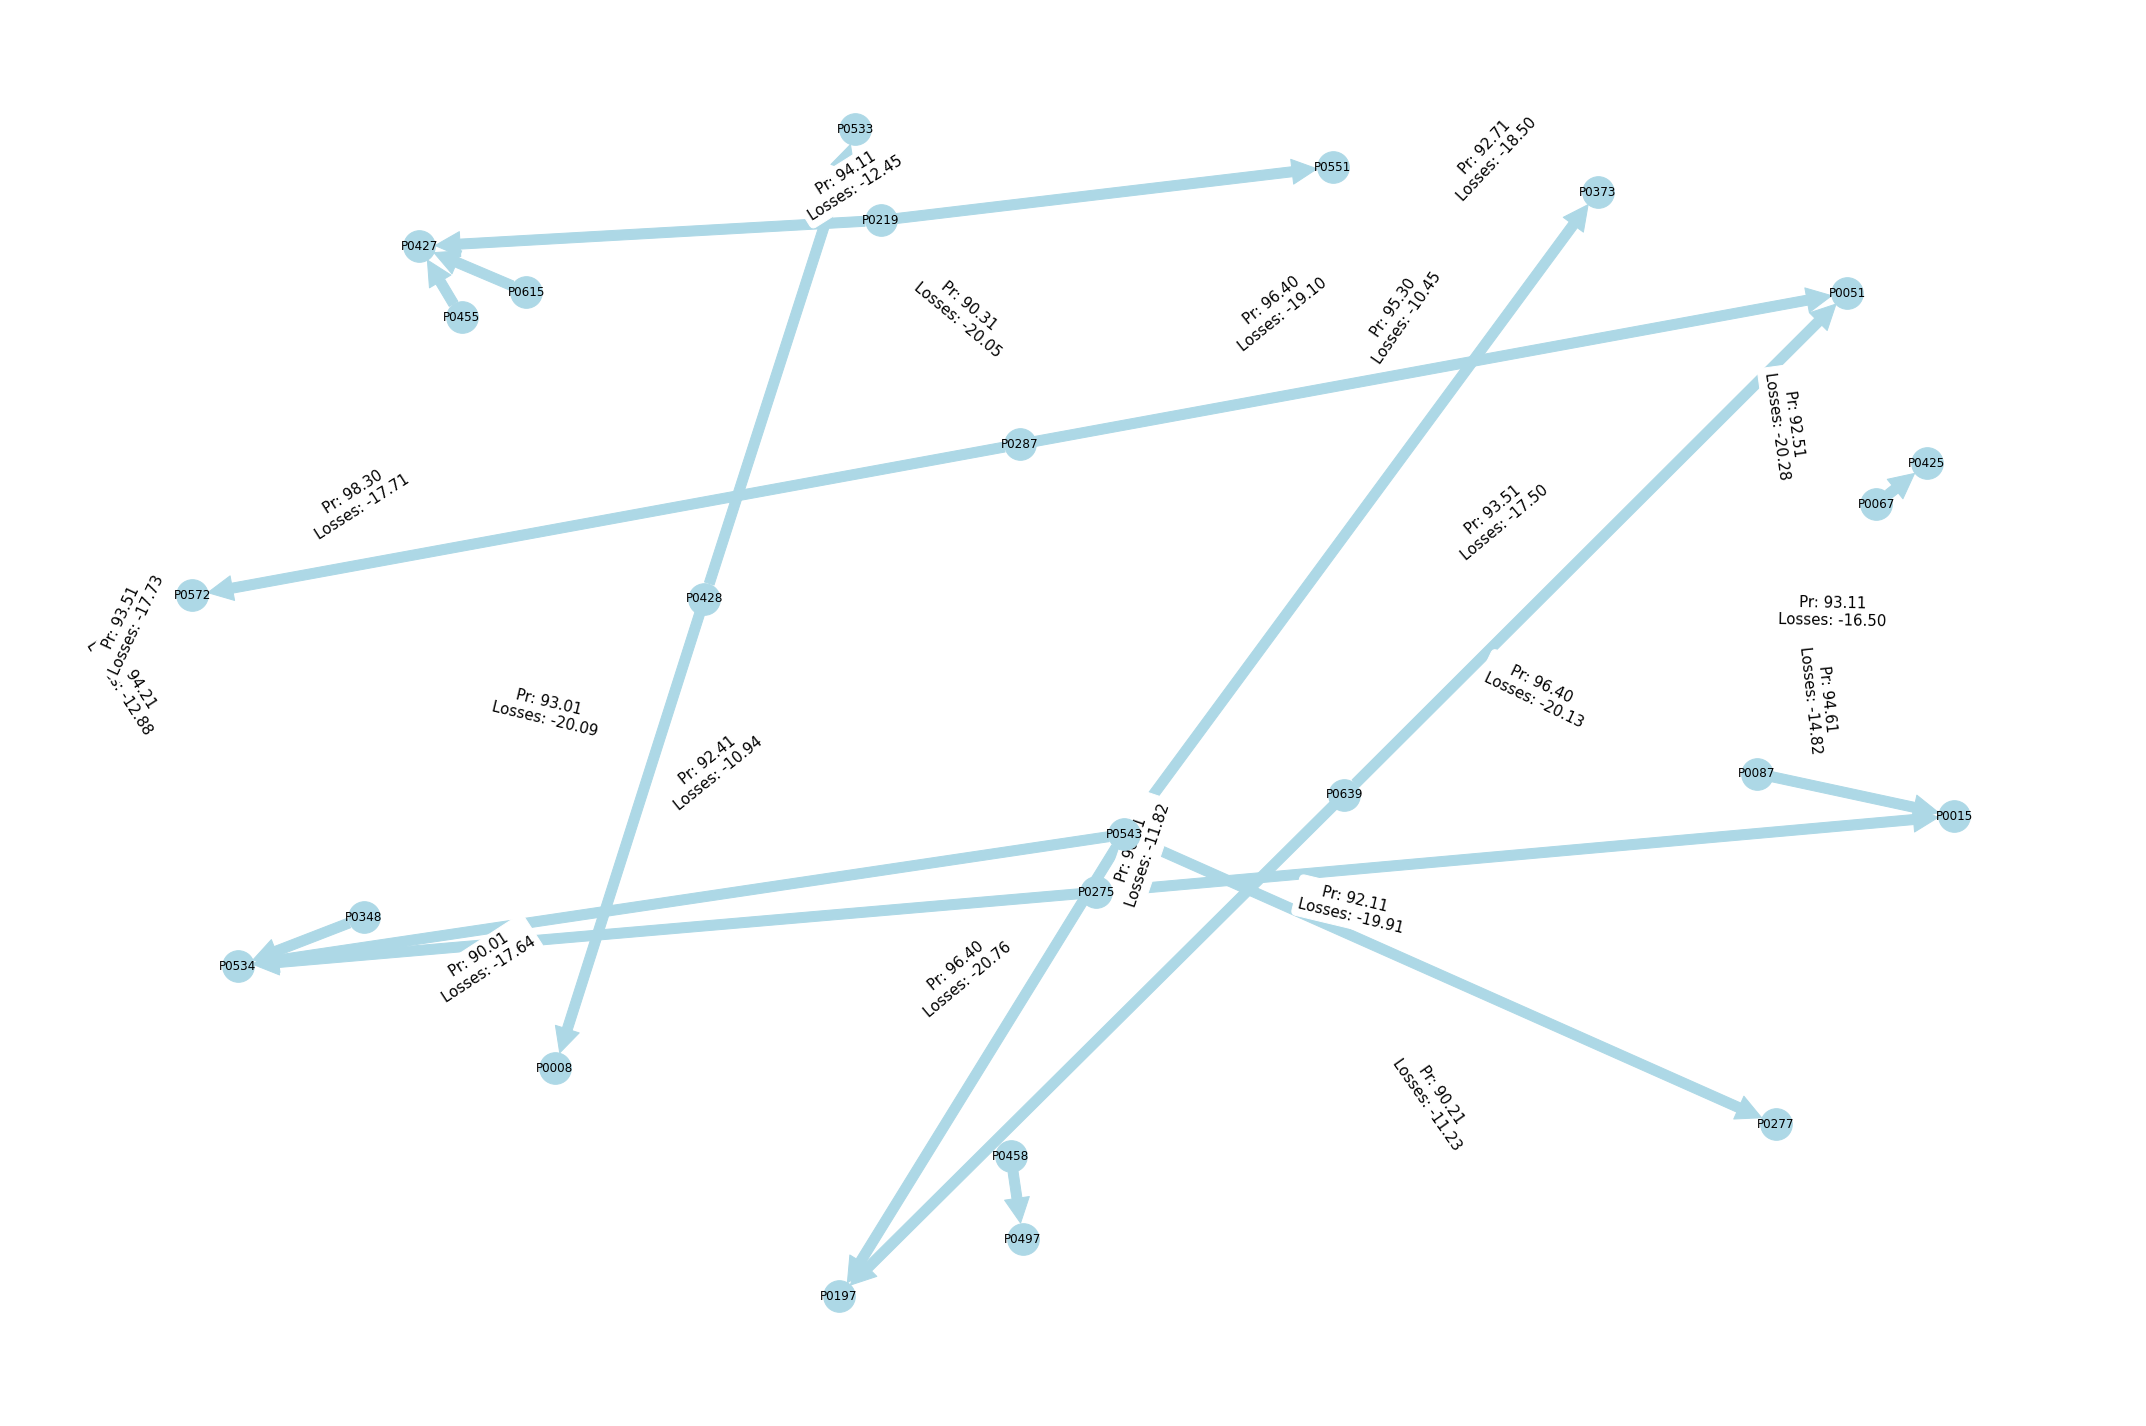

In [124]:
min_prob = 90.0
idx_A = df_CI_analysis.prob_causal_effect > min_prob
df_CI_analysis_paper = df_CI_analysis[
    (df_CI_analysis.prob_causal_effect > min_prob) & 
    (df_CI_analysis.store_id == store_id)
]
df_CI_analysis_paper.sort_values("prob_causal_effect", ascending=False, inplace=True)
df_CI_analysis_paper.drop_duplicates(subset=['product_id_A','product_id_B'], keep='first', inplace=True, ignore_index=True)
df_CI_analysis_paper.sort_values(by=['cum_abs_effect'], ascending=False, inplace=True)
print(df_CI_analysis_paper.shape)

max_episodes = 20

fig_h_graph = 20
fig_w_graph = 30

# main_font_size = 40
edge_font_size = 15

fig, ax = plt.subplots(1,1,figsize=(fig_w_graph,fig_h_graph))
text_offset = 0
DG = nx.DiGraph()

# plt.rcParams.update({'font.size': main_font_size})

df_CI_to_analyse = df_CI_analysis_paper[0:max_episodes].copy()
df_CI_to_analyse.rename(columns={'prob_causal_effect': 'Pr', 'cum_abs_effect': 'Losses'}, inplace=True)
vars_edges = ['Pr', 'Losses']

for item_id, df_row in df_CI_to_analyse.iterrows():
    node_A = {'name': df_row.product_id_A, 'properties': dict()}
    node_B = {'name': df_row.product_id_B, 'properties': dict()}

    edge_properties = df_row[vars_edges].to_dict()

    DG.add_node(node_A['name'], **node_A['properties'])

    DG.add_node(node_B['name'], **node_B['properties'])

    edge_label = '\n'.join([f'{k}: {v:3.2f}' for k,v in edge_properties.items()])
    DG.add_edge(node_A['name'], node_B['name'], **edge_properties, label=edge_label)

nx.draw(DG,
    node_color='lightblue',
    linewidths=1.0, 
    node_size=1000,
    with_labels=True, 
    edge_color='lightblue', 
    arrowsize=50,
    arrowstyle='simple')

labels = nx.get_edge_attributes(DG, 'label')
pos = nx.spring_layout(DG)
nx.draw_networkx_edge_labels(DG, pos, edge_labels=labels, font_size=edge_font_size)

net = Network(notebook=True)
net.from_nx(DG)
net.show('./data/cannibalization_network.html')
plt.tight_layout()